In [1]:

import pandas as pd
import warnings
import numpy as np
# 完全忽略PerformanceWarning
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:

combined_df=pd.read_hdf('combined_df_test.h5', key='df')

In [3]:
time_steps=150
VX_time1 = [f'VX_{i}h' for i in range(0, time_steps + 1)]
SYMH_time2 = [f'SYMH_{i}h' for i in range(0, time_steps + 1)]
VX_IS1_time3 = [f'VX_IS1_{i}h' for i in range(0, time_steps + 1)]
BZGSM_time4 = [f'BZGSM_{i}h' for i in range(0, time_steps + 1)]
TEMP_time5 = [f'TEMP_{i}h' for i in range(0, time_steps + 1)]
PDYN_time6 = [f'PDYN_{i}h' for i in range(0, time_steps + 1)]
Kp_time7 = [f'Kp_{i}h' for i in range(0, time_steps + 1)]
Dst_time8 = [f'Dst_{i}h' for i in range(0, time_steps + 1)]
F107_time9 = [f'F107_{i}h' for i in range(0, time_steps + 1)]
AE_time10 = [f'AE_{i}h' for i in range(0, time_steps + 1)]
AL_time11 = [f'AL_{i}h' for i in range(0, time_steps + 1)]
AU_time12 = [f'AU_{i}h' for i in range(0, time_steps + 1)]
BZGSM_IS1_time13 = [f'BZGSM_IS1_{i}h' for i in range(0, time_steps + 1)]
TEMP_IS1_time14 = [f'TEMP_IS1_{i}h' for i in range(0, time_steps + 1)]
PDYN_IS1_time15 = [f'PDYN_IS1_{i}h' for i in range(0, time_steps + 1)]
F107_IS1_time16 = [f'F107_IS1_{i}h' for i in range(0, time_steps + 1)]


In [4]:
X_time1 = combined_df[VX_time1].values  
X_time2 = combined_df[SYMH_time2].values 
X_time3 = combined_df[VX_IS1_time3].values
X_time4 = combined_df[BZGSM_time4].values
X_time5 = combined_df[TEMP_time5].values
X_time6 = combined_df[PDYN_time6].values
X_time7 = combined_df[Kp_time7].values
X_time8 = combined_df[Dst_time8].values
X_time9 = combined_df[F107_time9].values
X_time10 = combined_df[AE_time10].values
X_time11 = combined_df[AL_time11].values
X_time12 = combined_df[AU_time12].values
X_time13 = combined_df[BZGSM_IS1_time13].values
X_time14 = combined_df[TEMP_IS1_time14].values
X_time15 = combined_df[PDYN_IS1_time15].values
X_time16 = combined_df[F107_IS1_time16].values


X_time = np.stack((X_time1, X_time2,X_time3,X_time4,X_time5,X_time6,X_time7,X_time8,X_time9,X_time10,X_time11,X_time12,X_time13,X_time14,X_time15,X_time16), axis=2)
print(X_time.shape)
# 定义非时间序列特征列
non_time_features = ['I', 'MLT','Interpolated_Lstar', 'u']

# 提取非时间序列数据
X_non_time = combined_df[non_time_features].values  # 形状 (num_samples, 3)
y = np.log10(combined_df['PSD'].values+1e-8 ) # 形状 (num_samples,)

# 如果是二分类任务，将其转换为二维数组
y = y.reshape(-1, 1)  # 形状 (num_samples, 1)
flux_error = combined_df['Flux_Error'].values.reshape(-1, 1)

(886347, 151, 16)


In [5]:
scaler_time = MinMaxScaler()
num_samples = X_time.shape[0]
time_steps = 151  # 根据您的数据调整
num_features = 16  # 您有16个时间序列特征
X_time_reshaped = X_time.reshape(-1, num_features)  # (num_samples * time_steps, 16)
X_time_scaled = scaler_time.fit_transform(X_time_reshaped)
X_time = X_time_scaled.reshape(num_samples, time_steps, num_features)
scaler_non_time = StandardScaler()
X_non_time = scaler_non_time.fit_transform(X_non_time)
scaler_target = MinMaxScaler()
y_scaled = scaler_target.fit_transform(y)


# 归一化 Flux_Error
scaler_flux = MinMaxScaler()
flux_error_scaled = scaler_flux.fit_transform(flux_error)  # 缩放到 [0, 1]

# 反转权重（假设较高的 Flux_Error 表示较低的质量）
flux_error_reversed = 1 - flux_error_scaled 
min_weight = 0.2
flux_error_final = flux_error_reversed * (1 - min_weight) + min_weight  # 缩放到 [min_weight, 1]

In [6]:
print(X_non_time[:,2].min(), X_non_time[:,2].max())
original_value = 2.6

# 使用 scaler_non_time 转换原始值为标准化后的值
scaled_value = scaler_non_time.transform([[0, 0, original_value, 0]])

L_YZ=scaled_value[0,2]
print(L_YZ)

-2.4278160806195594 1.8030977576785574
-1.268632088972343


In [7]:
X_time_train, X_time_val, X_non_time_train, X_non_time_val, y_train, y_val, weight_train, weight_val = train_test_split(
    X_time, X_non_time, y_scaled, flux_error_final, test_size=0.2, random_state=42
)

In [8]:
#读入模型
model = tf.keras.models.load_model('LSTM_HIGH_0_model.h5')


4699/4699 [==============================] - 13s 3ms/step
测试集上的 RMSE: 0.13216819950003822 测试集上的 R2: 0.9842065881944856
测试集上的 RMSE_10: 3.440824723425858e-06
预测效率 (PE): 0.9842065881944856


d:\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


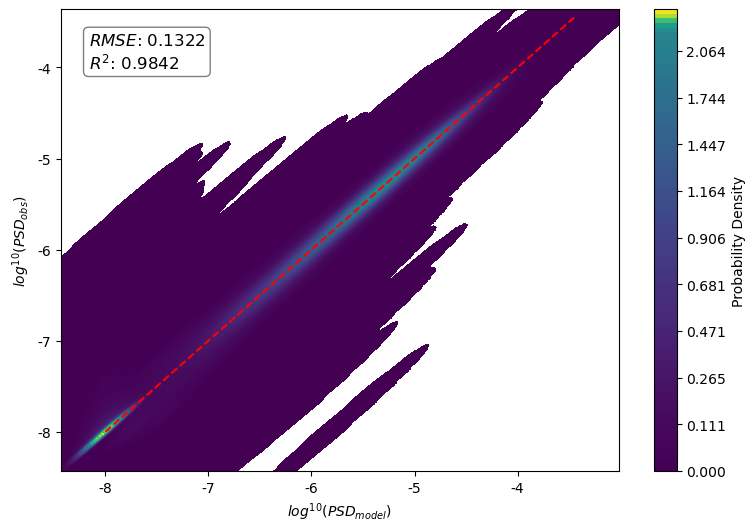

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# 显示负号
plt.rcParams['axes.unicode_minus'] = False

mask = X_non_time_val[:,2] < L_YZ
X_non_time_val_out = X_non_time_val[~mask]
X_time_val_out = X_time_val[~mask]
y_val_out = y_val[~mask]

y_pred_scaled = model.predict([X_time_val_out, X_non_time_val_out])

# 反缩放预测结果
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_test_subset = scaler_target.inverse_transform(y_val_out)
# 生成布尔掩码


y_test_exp = y_test_subset.flatten()
y_pred_exp = y_pred.flatten()

# 计算均方根误差（RMSE）
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
r2 = r2_score(y_test_subset, y_pred)
print(f'测试集上的 RMSE: {rmse}',f'测试集上的 R2: {r2}')

y_test_10 = 10**y_test_exp
y_pred_10 = 10**y_pred_exp
rmse_10 = np.sqrt(mean_squared_error(y_test_10, y_pred_10)) 
print(f'测试集上的 RMSE_10: {rmse_10}')

# 计算PE
observed_values = y_test_exp  # 真实值
predicted_values = y_pred_exp  # 预测值
mean_observed = np.mean(observed_values)  # 真实值的均值

# 计算PE
numerator = np.sum((observed_values - predicted_values) ** 2)
denominator = np.sum((observed_values - mean_observed) ** 2)

pe = 1 - (numerator / denominator)

print(f'预测效率 (PE): {pe}')





# 创建绘图
plt.figure(figsize=(9, 6))

# 使用 Seaborn 的 kdeplot 绘制联合概率密度图
ax = sns.kdeplot(
    x=y_test_exp, 
    y=y_pred_exp, 
    cmap='viridis', 
    fill=True, 
    thresh=0, 
    levels=100,
    bw_adjust=1.5
)

# 添加理想拟合线
plt.plot(
    [y_test_exp.min(), y_test_exp.max()], 
    [y_test_exp.min(), y_test_exp.max()], 
    'r--', 
    label='理想拟合线'
)

# 提取绘图的颜色集合（PolyCollection）
collections = ax.collections


if collections:
    # 创建颜色条，基于第一个集合（KDE 图）
    cbar = plt.colorbar(collections[0], ax=ax)
    cbar.set_label('Probability Density')

ax.text(
    0.05, 0.95, 
    f'$RMSE$: {rmse:.4f}\n$R^2$: {r2:.4f}', 
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)
# plt.xlim(-10, -6)
# plt.ylim(-10, -6)
# # 添加图例
# plt.legend()

# 设置坐标轴标签和标题
plt.xlabel('$log^{10}(PSD_{model})$')
plt.ylabel('$log^{10}(PSD_{obs})$')
# plt.title('真实值与预测值的概率密度图')

# 显示图形
plt.show()
